First set up the correct paths pointing to the directories containing the images, bounding boxes and instances.

In [1]:
# Settings
kitti_img_dir = "/mnt/e/DataSet/kitti/training/image_2"
kitti_box_dir = "/mnt/e/DataSet/kitti/training/label_2"
kitti_inst_dir = "/mnt/e/DataSet/kitti/training/instance_2"

In [2]:
# Imports
import colorsys
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import skimage.io as io

%load_ext autoreload
%autoreload 2

In [4]:
# Function definitions

HSV_mapping = {
#  ID:  [ H_min, H_max,    S,   v ]
    0:  [  0.00,  1.00, 0.00, 0.0 ], # Background
    1:  [  0.00,  1.00, 1.00, 0.9 ], # Vehicle linked to box
    2:  [  0.00,  1.00, 1.00, 0.9 ], # Pedestrian linked to box
    3:  [  0.00,  1.00, 0.40, 0.6 ], # Vehicle or Pedestrian without box 
}


def load_boxes(path):
    """Load KITTI3D bounding boxes.
    
    Args:
        path (str): Absolute path to object annotation txt file.
        
    Returns:
        boxes (DataFrame): Pandas DataFrame containing object annotations.
    """
    return pd.read_csv(
        path,
        sep=" ",
        names=('type',    'truncation',  'occlusion',  'alpha',   'left',  'top',   'right',  'bottom',
               'height',  'width',       'length',     'x',       'y',     'z',     'ry',     'tid' )
    )


def draw_boxes(img, boxes):
    """Draw 2d object boxes on top of image for visualisation.
    
    Args:
        img (np.array): Image to draw on.
        boxes (DataFrame): Pandas DataFrame containing object annotations.
        
    Returns:
        img (np.array): Image with drawn objects.
    """
    class_map = {
        'Car': 1,
        'Truck': 1,
        'Van': 1,
        'Pedestrian': 2,
        'Person_sitting': 2,
        'Cyclist': 0,
        'DontCare': 0,
        'Misc': 0,
        'Tram': 0
    }
    for i in range(len(boxes)):
        obj_class = class_map[boxes['type'][i]]
        if obj_class==0: continue
        hue_min, hue_max, saturation, value = HSV_mapping[obj_class]
        color = get_rgb_from_id(int(i), hue_min, hue_max, saturation=saturation, value=value)
        cv2.rectangle(
            img=img, 
            pt1=(int(boxes['left'][i]), int(boxes['top'][i])),
            pt2=(int(boxes['right'][i]), int(boxes['bottom'][i])), 
            color=color*255,
            thickness=2
        )
    return img


def map_instance_to_color(instances, HSV_mapping=HSV_mapping):
    """Map instances to the corresponding colors.

    Args:
        instances (np.array): Instance array. [ H x W ]
        HSV_mapping (dict, optional): Dictionary containing for every instance class a list with [hue_min, hue_max, saturation, value].

    Returns:
        np.array: Array containing the color coded instances [ H x W x 3]
    """
    assert isinstance(instances, np.ndarray), f"'instances' must be of type np.array, not {type(instances)}"
    # Get unique instances
    uniques, instance_map = np.unique(instances, return_inverse=True)
    # Make color_map
    color_map = []
    for instance_id in uniques:
        # Determine color range
        segm_class = instance_id//1000
        box_id = instance_id%1000
        hue_min, hue_max, saturation, value = HSV_mapping.get(segm_class, [0, 1, 1, 1])
        # Get color for each instance
        color_map.append(get_rgb_from_id(int(box_id), hue_min, hue_max, saturation=saturation, value=value))
    color_map = np.array(color_map)
    # Create colored instance image
    instance_map = color_map[instance_map.reshape(instances.shape)]
    return instance_map


def get_rgb_from_id(instance_id, hue_min=0, hue_max=1, saturation=0.9, value=0.9):
    """Map an instance/bbox id to a unique color.

    Args:
        instance_id (int): Value representing a unique id.
        hue_min (float, optional): Minimum value for the hue range in which this id should be mapped. Should be greater than or equal to 0. Default: 0
        hue_max (float, optional): Maximum value for the hue range in which this id should be mapped. If larger than 1, hue value will loop back to 0. Default: 1
        saturation (float, optional): Value between 0 and 1 for saturation. Default: 0.9
        value (float, optional): Value between 0 and 1 for brightness. Default: 0.9

    Returns:
        np.array[(3,)]: Array containing the RGB values for this instance id, with values between 0 and 1.
    """
    assert isinstance(instance_id, (int, np.int32)), f"instance_id should be of type 'int', not '{type(instance_id)}'"
    assert isinstance(hue_min, (int, float)) and isinstance(hue_max, (int, float)), f"hue_min and hue_max should be of type 'float', not '{type(hue_min)}' and '{type(hue_max)}'"
    assert isinstance(saturation, (int, float)) and saturation >= 0 and saturation <= 1, f"saturation should be a float between 0 and 1, not '{saturation}'"
    assert isinstance(value, (int, float)) and value >= 0 and value <= 1, f"value should be a float between 0 and 1, not '{value}'"
    
    # Golden angle: equally distributed colors but as far appart as possible; Hue will be between 0 and 1
    golden_angle = 137/360
    h = (instance_id*golden_angle) % 1
    # Scale hue in range (hue_min, hue_max)
    h = h*(hue_max-hue_min) + hue_min
    # Get rgb values
    rgb = np.array(colorsys.hsv_to_rgb(h, saturation, value))
    return rgb


def plot_sample(i, kitti_img_dir, kitti_box_dir, kitti_inst_dir, alpha=0.6):
    """Visualise the instances and corresponding bounding boxes for a KITTI3D image.
    
    Args:
        i (int): Number of the image that needs to be shown.
        kitti_img_dir (str): Absolute path to the directory which contains the KITTI3D images.
        kitti_box_dir (str): Absolute path to the directory which contains the KITTI3D object annotations.
        kitti_inst_dir (str): Absolute path to the directory which contains our instance annotations.
    """
    # Get paths
    sample_name = f"{i:06d}"
    img_path = f"{kitti_img_dir}/{sample_name}.png"
    box_path = f"{kitti_box_dir}/{sample_name}.txt"
    inst_path = f"{kitti_inst_dir}/{sample_name}.png"

    # Load image, objects and instances
    img_inst = io.imread(img_path)
    img_box = img_inst.copy()
    boxes = load_boxes(box_path)
    inst = io.imread(inst_path)
    print(inst.shape)

    # Visualalise instances
    inst_color = map_instance_to_color(inst)
    print(inst_color.shape)
    mask = inst_color.sum(axis=2)
    img_inst[:] = img_inst[:]*0.5
    img_inst[mask!=0,:] = img_inst[mask!=0,:]*(1-alpha) + inst_color[mask!=0,:]*256*alpha
    # Visulaise boxes
    img_box = draw_boxes(img_box, boxes)
    
    # Create Figure
    plt.figure(figsize=(10,6))
    # Plot Instances
    ax1 = plt.subplot(2, 1, 1, frameon=False)
    ax1.imshow(img_inst)
    ax1.axis('off')
    plt.title(sample_name)
    # Plot Boxes
    ax2 = plt.subplot(2, 1, 2, frameon=False)
    ax2.imshow(img_box)
    ax2.axis('off')
    # Render
    plt.tight_layout()
    plt.show()

Instances which are matched to a bounding box annotation are shown in bright colors.
Instances without matches are shown in less saturated colors

这里发现一个问题：有些 instance 的 box_id 序列缺少项，我们会移除这些样本

In [99]:
import os
from tools.dataset_util import Dataset
from pathlib import Path

dataset = Dataset("train", r"/mnt/e/DataSet/kitti")
root_dir = Path(r"/mnt/e/DataSet/kitti/kitti_inst_database")
image_dir = root_dir / "image"
depth_dir = root_dir / "depth"

db = dict()

for idx in range(7481):
    name = str(idx).zfill(6)
    calib = dataset.get_calib(idx)
    plane = dataset.get_plane(idx)
    image, depth = dataset.get_image_with_depth(idx, use_penet=True)
    ground, non_ground = dataset.get_lidar_with_ground(idx, fov=True)
    bbox3d, bbox2d, labels = dataset.get_bbox(idx, chosen_cls=["Car", "Truck", "Van"])
    instance = dataset.get_instance(idx)
    uniques, instance_map = np.unique(instance, return_inverse=True)
    
    uniques = [uid for uid in uniques if str(uid).startswith("10")]
    if not all([i == uid % 1000 for i, uid in enumerate(uniques)]):
        print(name)
        continue
    
    for uid in uniques:
        seg = uid // 1000    # 1 for Car, Van, Truck
        if seg != 1:
            continue
        box_id = uid % 1000
        try:
            label = labels[box_id]
        except IndexError as e:
            continue
        if label.cls_type != "Car" or label.occlusion != 0 or label.trucation >= 1e-2:
            continue
        if label.pos[-1] > 30:
            continue
        
        mask = instance == uid
        masked_image = image * mask[:,:,np.newaxis]
        masked_depth = depth * mask
        
        mask = mask.astype(np.uint8) * 255
        
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        x, y, w_, h_ = cv2.boundingRect(contours[0])
        
        if w_ * h_ < 500:
            continue
        
        masked_image = masked_image[y:y+h_, x:x+w_]
        masked_depth = (masked_depth[y:y+h_, x:x+w_] * 256.0).astype(np.uint16)
        cv2.imwrite(str(image_dir / f"{name}_{box_id}.png"), masked_image)
        cv2.imwrite(str(depth_dir/ f"{name}_{box_id}.png"), masked_depth )
        
        db[f"{name}_{box_id}"] = {
            "label": label,
            "bbox2d": [x, y, x+w_, y+h_],
            "name": f"{name}_{box_id}",
            "calib": calib,
            "plane": plane
        }
    

000002
000010
000011
000021
000025
000029
000045
000047
000049
000051
000061
000063
000068
000075
000087
000091
000098
000102
000105
000113
000114
000119
000127
000129
000132
000134
000142
000144
000145
000146
000151
000152
000153
000154
000157
000161
000169
000174
000177
000183
000184
000186
000190
000192
000201
000203
000204
000205
000206
000207
000208
000210
000211
000214
000217
000228
000232
000245
000246
000248
000249
000254
000264
000266
000268
000273
000274
000277
000282
000295
000303
000305
000307
000310
000311
000314
000318
000330
000331
000332
000333
000335
000336
000339
000340
000345
000347
000351
000354
000357
000362
000369
000371
000377
000380
000382
000383
000386
000391
000393
000395
000401
000403
000408
000409
000412
000422
000423
000424
000427
000430
000432
000435
000436
000438
000442
000445
000446
000450
000453
000460
000461
000463
000464
000468
000469
000471
000478
000479
000480
000486
000488
000490
000492
000493
000495
000501
000505
000514
000518
000519
000522
000527

In [3]:
def get_contour(instance, uid):
    mask = instance == uid
    mask = mask.astype(np.uint8) * 255
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    x, y, w_, h_ = cv2.boundingRect(contours[0])
    return [x, y, x+w_, y+h_]

In [23]:
from tools.box_util import boxes_iou2d, find_best_match
import os
from tools.dataset_util import Dataset
from pathlib import Path

dataset = Dataset("train", r"/mnt/e/DataSet/kitti")
root_dir = Path(r"/mnt/e/DataSet/kitti/kitti_drx_database")
image_dir = root_dir / "image"
depth_dir = root_dir / "depth_dense"

db = dict()
for idx in range(7481):
    name = str(idx).zfill(6)
    calib = dataset.get_calib(idx)
    plane = dataset.get_plane(idx)
    image, depth = dataset.get_image_with_depth(idx, use_penet=False)
    ground, non_ground = dataset.get_lidar_with_ground(idx, fov=True)
    bbox3d, bbox2d, labels = dataset.get_bbox(idx, chosen_cls=["Car", "Truck", "Van"])
    instance = dataset.get_instance(idx)
    
    uniques, instance_map = np.unique(instance, return_inverse=True)
    uniques = [uid for uid in uniques if str(uid).startswith("10")]
    contours = np.array([get_contour(instance, uid) for uid in uniques])
    masks = [instance == uid for uid in uniques]
    if contours.shape[0] == 0 or bbox2d.shape[0] == 0:
        continue
    iou = boxes_iou2d(contours, bbox2d)
    matches = find_best_match(iou, 0.6)
    
    for i in range(len(uniques)):
        if matches[i] == -1:
            continue
        
        label = labels[matches[i]]
        if label.cls_type != "Car" or label.occlusion != 0 or label.trucation >= 1e-2:
            continue
        if label.pos[-1] < 50:
            continue
            
        mask, contour = masks[i], contours[i]
        x, y, x_, y_ = contour
        # if (x_ - x) * (y_ - y) < 300:
        #     continue
            
        masked_image = image * mask[:,:,np.newaxis]
        masked_depth = depth * mask
        masked_image = masked_image[y:y_, x:x_]
        masked_depth = (masked_depth[y:y_, x:x_] * 256.0).astype(np.uint16)
        cv2.imwrite(str(image_dir / f"{name}_{matches[i]}.png"), masked_image)
        cv2.imwrite(str(depth_dir/ f"{name}_{matches[i]}.png"), masked_depth )
        rx = np.arctan2(label.pos[2], label.pos[1] - label.h / 2)
        db[f"{name}_{matches[i]}"] = {
            "label": label,
            "bbox2d": [x, y, x_, y_],
            "name": f"{name}_{matches[i]}",
            "calib": calib,
            "plane": plane,
            "image_shape": image.shape[:2],
            "bbox3d": [*label.pos, label.l, label.h, label.w, label.ry],
            "z/y": rx * 180 / np.pi
        }

In [6]:
all_image = os.listdir(image_dir)
all_image = set([name.split('.')[0] for name in all_image])
all_key = set(db.keys())
print(all_key - all_image)
for name in all_key - all_image:
    del db[name]
    os.remove(depth_dir / (name + ".png"))

{'006820_8', '002404_3', '002497_1', '001123_1', '001733_4', '000362_6', '004551_2', '001380_1', '007222_4', '004520_6', '005669_0', '005371_4', '000915_0', '001840_6', '003986_4', '002746_4', '002748_5', '001179_0'}


#### 添加其他数据

In [1]:
import pickle
from pathlib import Path
from tools.dataset_util import Dataset
dataset = Dataset("train", r"/mnt/e/DataSet/kitti")
root_dir = Path(r"/mnt/e/DataSet/kitti/kitti_inst_database")
image_dir = root_dir / "image"
depth_dir = root_dir / "depth"

with open(root_dir / "kitti_car_database.pkl", "rb") as f:
    db = pickle.load(f)

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [3]:
db

{'000003_0': {'label': Car 0.000 0.000 pos: [ 1.    1.75 13.22],
  'bbox2d': [606, 182, 722, 282],
  'name': '000003_0',
  'calib': <lib.datasets.kitti_utils.Calibration at 0x7f25912e5af0>,
  'plane': array([-0.04009626, -0.9986394 ,  0.03334112,  1.47307001]),
  'image_shape': (375, 1242)},
 '000006_2': {'label': Car 0.000 0.000 pos: [-12.54   1.64  19.72],
  'bbox2d': [47, 186, 224, 241],
  'name': '000006_2',
  'calib': <lib.datasets.kitti_utils.Calibration at 0x7f25912e5f70>,
  'plane': array([-0.01691065, -0.99974672, -0.01485037,  1.66484703]),
  'image_shape': (374, 1238)},
 '000007_0': {'label': Car 0.000 0.000 pos: [-0.69  1.69 25.01],
  'bbox2d': [564, 176, 618, 223],
  'name': '000007_0',
  'calib': <lib.datasets.kitti_utils.Calibration at 0x7f25912fb3d0>,
  'plane': array([-1.94987805e-02, -9.99809725e-01, -5.57546514e-04,  1.72167804e+00]),
  'image_shape': (375, 1242)},
 '000008_5': {'label': Car 0.000 0.000 pos: [ 8.48  1.75 19.96],
  'bbox2d': [887, 179, 954, 239],
  'n

In [9]:
for sample in db.values():
    name = sample['name']
    idx = int(name.split('_')[0])
    image = dataset.get_image(idx)
    sample['image_shape'] = image.shape[:2]

In [8]:
import pickle
with open(root_dir / "kitti_car_database.pkl", "wb") as f:
    pickle.dump(db, f)

是这样的，我发现 depth_dense 可能是真值，而 penet 只是个捞比，所以我打算换用 depth_dense。

In [10]:
import os
import cv2
import numpy as np

save_dir = root_dir / "depth_dense"
all_sample = os.listdir(depth_dir)
for sample_file in all_sample:
    sample_name = sample_file.split('.')[0]
    idx = int(sample_name.split('_')[0])
    u_min, v_min, u_max, v_max = db[sample_name]['bbox2d']
    depth_penet = cv2.imread(str(depth_dir / sample_file), cv2.IMREAD_UNCHANGED)
    mask = depth_penet != 0
    
    rgb, depth = dataset.get_image_with_depth(idx)
    depth_dense = depth[v_min: v_max, u_min:u_max]
    depth_dense[~mask] = 0
    depth_dense = (depth_dense * 256.).astype(np.uint16)
    cv2.imwrite(str(save_dir / sample_file), depth_dense)
    print(sample_name)
    


000003_0
000006_2
000007_0
000008_5
000009_0
000010_1
000010_2
000010_4
000011_0
000013_0
000019_1
000020_0
000021_0
000021_3
000025_1
000025_3
000031_0
000031_1
000031_4
000032_0
000032_1
000034_0
000035_1
000036_0
000037_0
000038_0
000038_5
000039_1
000044_1
000045_0
000045_1
000046_0
000047_0
000047_2
000047_4
000049_0
000049_1
000050_0
000050_1
000052_0
000052_5
000053_1
000053_2
000053_3
000053_5
000059_2
000060_1
000062_0
000063_0
000064_0
000064_1
000067_3
000067_4
000069_0
000071_0
000072_1
000075_1
000079_3
000080_0
000080_3
000083_1
000083_2
000083_3
000084_0
000087_0
000089_0
000090_0
000092_1
000093_1
000094_0
000095_0
000095_1
000098_0
000098_1
000099_2
000099_3
000101_0
000101_2
000104_0
000107_3
000108_0
000110_3
000110_4
000111_0
000111_3
000113_4
000113_5
000113_7
000114_0
000116_0
000116_1
000116_2
000117_0
000119_0
000119_2
000120_2
000120_6
000122_0
000126_0
000127_0
000128_1
000129_0
000129_1
000131_1
000134_0
000138_0
000138_1
000140_0
000140_1
000141_0
000144_1
0

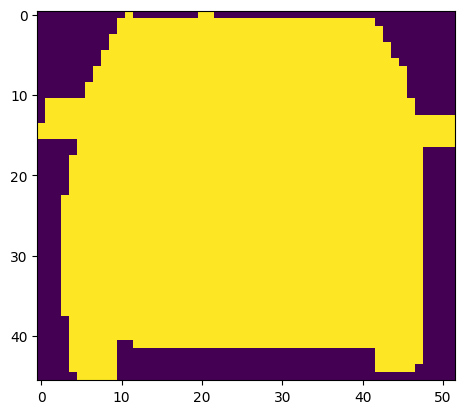

In [7]:
from tools.visualize_util import plt_show
plt_show(mask, rgb=False)

In [40]:
dataset = Dataset("train", r"/mnt/e/DataSet/kitti")
root_dir = Path(r"/mnt/e/DataSet/kitti/kitti_drx_database")
image_dir = root_dir / "image"
depth_dir = root_dir / "depth_dense"

image_db = {}
depth_db = {}
all_image = os.listdir(image_dir)

for file_name in all_image:
    name = file_name.split('.')[0]
    image_db[name] = cv2.imread(str(image_dir / file_name))
    depth_db[name] = cv2.imread(str(depth_dir / file_name), cv2.IMREAD_UNCHANGED) / 256.0
    print(name)

000001_1
000002_0
000003_0
000004_0
000004_1
000006_1
000006_2
000007_0
000007_1
000007_2
000008_4
000008_5
000009_0
000009_2
000010_1
000010_2
000010_4
000011_0
000012_0
000013_0
000014_0
000016_2
000016_4
000017_0
000018_0
000019_1
000019_3
000020_0
000021_0
000021_3
000023_1
000024_0
000024_1
000025_1
000025_2
000025_3
000026_1
000027_1
000029_0
000030_0
000031_0
000031_1
000031_4
000032_0
000032_1
000032_9
000033_0
000034_0
000035_0
000035_1
000036_0
000036_1
000036_2
000036_3
000037_0
000038_0
000038_5
000038_9
000039_1
000039_2
000040_0
000042_0
000044_1
000045_0
000045_1
000045_4
000046_0
000046_4
000047_0
000047_2
000047_4
000049_0
000049_1
000050_0
000050_1
000050_3
000051_0
000052_0
000052_5
000053_1
000053_2
000053_3
000053_5
000056_0
000057_1
000057_2
000059_0
000059_1
000059_2
000060_1
000062_0
000062_2
000063_0
000064_0
000064_1
000066_0
000066_1
000067_0
000067_2
000067_3
000067_4
000069_0
000071_0
000072_1
000072_2
000075_1
000077_0
000078_2
000078_3
000079_0
000079_2
0

In [51]:
with open(root_dir / "sample_depth_dense_database_with_flip.pkl", "wb") as f:
    pickle.dump(depth_db, f)
with open(root_dir / "sample_image_database_with_flip.pkl", "wb") as f:
    pickle.dump(image_db, f)

In [37]:
import pickle
import pandas as pd
from pathlib import Path
from tools.dataset_util import Dataset

dataset = Dataset("train", r"/mnt/e/DataSet/kitti")
root_dir = Path(r"/mnt/e/DataSet/kitti/kitti_drx_database")
image_dir = root_dir / "image"
depth_dir = root_dir / "depth_dense"

db = pd.read_pickle(str(root_dir / 'kitti_car_database.pkl'))
db.head(10)

,label,bbox2d,name,calib,plane,image_shape,bbox3d,z/y,x,y,z,l,h,w,ry,x/z,idx
0,Car 0.000 0.000 pos: [-16.53 2.39 58.49],"[389, 181, 420, 201]",000001_1,<lib.datasets.kitti_utils.Calibration object a...,"[-0.018513719307718522, -0.9998284626135238, -...","(375, 1242)","[-16.53, 2.39, 58.49, 3.69, 1.67, 1.87, 1.57]",88.477108,-16.530001,2.39,58.490002,3.69,1.67,1.87,1.57,-15.780951,000001
1,Car 0.000 0.000 pos: [-15.89 2.23 51.17],"[366, 184, 404, 204]",000004_1,<lib.datasets.kitti_utils.Calibration object a...,"[-0.012236349528411058, -0.9999068614635871, 0...","(375, 1242)","[-15.89, 2.23, 51.17, 3.41, 1.38, 1.8, 1.58]",88.276160,-15.890000,2.23,51.169998,3.41,1.38,1.80,1.58,-17.251322,000004
2,Car 0.000 0.000 pos: [-4.71 1.71 60.52],"[542, 176, 564, 195]",000007_2,<lib.datasets.kitti_utils.Calibration object a...,"[-0.01949878049240585, -0.9998097252483562, -0...","(375, 1242)","[-4.71, 1.71, 60.52, 4.05, 1.46, 1.66, 1.56]",89.072291,-4.710000,1.71,60.520000,4.05,1.46,1.66,1.56,-4.450103,000007
3,Car 0.000 0.000 pos: [-2.19 1.96 68.25],"[573, 177, 598, 194]",000009_2,<lib.datasets.kitti_utils.Calibration object a...,"[-0.01492800041790388, -0.9998797279912651, 0....","(375, 1242)","[-2.19, 1.96, 68.25, 3.37, 1.41, 1.53, 1.75]",88.946548,-2.190000,1.96,68.250000,3.37,1.41,1.53,1.75,-1.837872,000009
4,Car 0.000 0.000 pos: [ 5.35 2.56 58.84],"[662, 186, 690, 204]",000012_0,<lib.datasets.kitti_utils.Calibration object a...,"[-0.007847468025297224, -0.9997990032229681, 0...","(375, 1242)","[5.35, 2.56, 58.84, 3.51, 1.48, 1.36, -1.75]",88.228330,5.350000,2.56,58.840000,3.51,1.48,1.36,-1.75,5.195306,000012
5,Car 0.000 0.000 pos: [ 2.57 1.72 59.81],"[626, 175, 652, 194]",000014_0,<lib.datasets.kitti_utils.Calibration object a...,"[-0.006436642123378671, -0.9999783191677576, 0...","(375, 1242)","[2.57, 1.72, 59.81, 4.39, 1.44, 1.68, 1.77]",89.042126,2.570000,1.72,59.810001,4.39,1.44,1.68,1.77,2.460452,000014
6,Car 0.000 0.000 pos: [-3.85 2.52 59.59],"[552, 184, 575, 204]",000019_3,<lib.datasets.kitti_utils.Calibration object a...,"[-0.038537290611079196, -0.9991616158435339, 0...","(375, 1242)","[-3.85, 2.52, 59.59, 3.91, 1.58, 1.65, -1.55]",88.337072,-3.850000,2.52,59.590000,3.91,1.58,1.65,-1.55,-3.696637,000019
7,Car 0.000 0.000 pos: [-16.57 2.43 55.08],"[373, 181, 408, 203]",000023_1,<lib.datasets.kitti_utils.Calibration object a...,"[-0.01867382918423246, -0.9998249563225765, -0...","(375, 1242)","[-16.57, 2.43, 55.08, 3.69, 1.67, 1.87, 1.57]",88.341299,-16.570000,2.43,55.080002,3.69,1.67,1.87,1.57,-16.743134,000023
8,Car 0.000 0.000 pos: [-4.22 1.7 68.34],"[554, 176, 576, 191]",000026_1,<lib.datasets.kitti_utils.Calibration object a...,"[-0.026179510958410215, -0.9996393365959683, 0...","(375, 1242)","[-4.22, 1.7, 68.34, 3.64, 1.53, 1.59, -1.73]",89.216151,-4.220000,1.70,68.339996,3.64,1.53,1.59,-1.73,-3.533532,000026
9,Car 0.000 0.000 pos: [-1.15 2.16 73.46],"[590, 181, 606, 195]",000027_1,<lib.datasets.kitti_utils.Calibration object a...,"[-0.013445599830376194, -0.9998725873860448, 0...","(375, 1242)","[-1.15, 2.16, 73.46, 3.56, 1.26, 1.6, -1.59]",88.806835,-1.150000,2.16,73.459999,3.56,1.26,1.60,-1.59,-0.896879,000027


In [38]:
import numpy as np
from copy import deepcopy

def flip_sample(sample):
    sample = deepcopy(sample)
    calib = deepcopy(sample['calib'])
    h, w = sample['image_shape']
    calib.flip([w, h])
    u_min, v_min, u_max, v_max = sample['bbox2d'].copy()
    sample['bbox2d'] = [w - u_max, v_min, w - u_min, v_max]
    
    bbox3d = sample['bbox3d'].copy()
    label = deepcopy(sample['label'])
    label.box2d = np.array([w - u_max, v_min, w - u_min, v_max], dtype=np.float32)
    ry = np.pi - sample['label'].ry
    if ry > np.pi: ry -= 2 * np.pi
    if ry < -np.pi: ry += 2 * np.pi
    label.ry = ry
    bbox3d[-1] = ry
    label.pos[0] *= -1
    bbox3d[0] *= -1
    sample['bbox3d'] = bbox3d
    label.alpha = calib.ry2alpha(ry, w - (u_max + u_min) / 2)
    sample['label'] = label
    sample['calib'] = calib
    plane = sample['plane'].copy()
    plane[0] *= -1
    sample['plane'] = plane
    
    sample['flipped'] = True
    
    name = sample['name'].split('_')
    name[1] = str(100 + int(name[1]))
    sample['name'] = '_'.join(name)
    
    sample['z/y'] = np.arctan2(label.pos[2], label.pos[1] - label.h / 2) * 180 / np.pi
    sample['x'] = bbox3d[0]
    sample['ry'] = bbox3d[-1]
    sample['x/z'] = np.arctan2(label.pos[0], label.pos[2]) * 180 / np.pi
    return sample
    
db_flip = db.apply(flip_sample, axis=1)



In [39]:
db_flip.head(10)

,label,bbox2d,name,calib,plane,image_shape,bbox3d,z/y,x,y,z,l,h,w,ry,x/z,idx,flipped
0,Car 0.000 0.000 pos: [16.53 2.39 58.49],"[822, 181, 853, 201]",000001_101,<lib.datasets.kitti_utils.Calibration object a...,"[0.018513719307718522, -0.9998284626135238, -0...","(375, 1242)","[16.530000686645508, 2.39, 58.49, 3.69, 1.67, ...",88.477108,16.530001,2.39,58.490002,3.69,1.67,1.87,1.571593,15.780951,000001,True
1,Car 0.000 0.000 pos: [15.89 2.23 51.17],"[838, 184, 876, 204]",000004_101,<lib.datasets.kitti_utils.Calibration object a...,"[0.012236349528411058, -0.9999068614635871, 0....","(375, 1242)","[15.890000343322754, 2.23, 51.17, 3.41, 1.38, ...",88.276160,15.890000,2.23,51.169998,3.41,1.38,1.80,1.561593,17.251321,000004,True
2,Car 0.000 0.000 pos: [ 4.71 1.71 60.52],"[678, 176, 700, 195]",000007_102,<lib.datasets.kitti_utils.Calibration object a...,"[0.01949878049240585, -0.9998097252483562, -0....","(375, 1242)","[4.710000038146973, 1.71, 60.52, 4.05, 1.46, 1...",89.072291,4.710000,1.71,60.520000,4.05,1.46,1.66,1.581593,4.450103,000007,True
3,Car 0.000 0.000 pos: [ 2.19 1.96 68.25],"[644, 177, 669, 194]",000009_102,<lib.datasets.kitti_utils.Calibration object a...,"[0.01492800041790388, -0.9998797279912651, 0.0...","(375, 1242)","[2.190000057220459, 1.96, 68.25, 3.37, 1.41, 1...",88.946548,2.190000,1.96,68.250000,3.37,1.41,1.53,1.391593,1.837872,000009,True
4,Car 0.000 0.000 pos: [-5.35 2.56 58.84],"[552, 186, 580, 204]",000012_100,<lib.datasets.kitti_utils.Calibration object a...,"[0.007847468025297224, -0.9997990032229681, 0....","(375, 1242)","[-5.349999904632568, 2.56, 58.84, 3.51, 1.48, ...",88.228330,-5.350000,2.56,58.840000,3.51,1.48,1.36,-1.391593,-5.195307,000012,True
5,Car 0.000 0.000 pos: [-2.57 1.72 59.81],"[590, 175, 616, 194]",000014_100,<lib.datasets.kitti_utils.Calibration object a...,"[0.006436642123378671, -0.9999783191677576, 0....","(375, 1242)","[-2.569999933242798, 1.72, 59.81, 4.39, 1.44, ...",89.042126,-2.570000,1.72,59.810001,4.39,1.44,1.68,1.371593,-2.460452,000014,True
6,Car 0.000 0.000 pos: [ 3.85 2.52 59.59],"[667, 184, 690, 204]",000019_103,<lib.datasets.kitti_utils.Calibration object a...,"[0.038537290611079196, -0.9991616158435339, 0....","(375, 1242)","[3.8499999046325684, 2.52, 59.59, 3.91, 1.58, ...",88.337072,3.850000,2.52,59.590000,3.91,1.58,1.65,-1.591593,3.696637,000019,True
7,Car 0.000 0.000 pos: [16.57 2.43 55.08],"[834, 181, 869, 203]",000023_101,<lib.datasets.kitti_utils.Calibration object a...,"[0.01867382918423246, -0.9998249563225765, -0....","(375, 1242)","[16.56999969482422, 2.43, 55.08, 3.69, 1.67, 1...",88.341299,16.570000,2.43,55.080002,3.69,1.67,1.87,1.571593,16.743133,000023,True
8,Car 0.000 0.000 pos: [ 4.22 1.7 68.34],"[666, 176, 688, 191]",000026_101,<lib.datasets.kitti_utils.Calibration object a...,"[0.026179510958410215, -0.9996393365959683, 0....","(375, 1242)","[4.21999979019165, 1.7, 68.34, 3.64, 1.53, 1.5...",89.216151,4.220000,1.70,68.339996,3.64,1.53,1.59,-1.411593,3.533532,000026,True
9,Car 0.000 0.000 pos: [ 1.15 2.16 73.46],"[636, 181, 652, 195]",000027_101,<lib.datasets.kitti_utils.Calibration object a...,"[0.013445599830376194, -0.9998725873860448, 0....","(375, 1242)","[1.149999976158142, 2.16, 73.46, 3.56, 1.26, 1...",88.806835,1.150000,2.16,73.459999,3.56,1.26,1.60,-1.551593,0.896880,000027,True


In [40]:
db.head(10)

,label,bbox2d,name,calib,plane,image_shape,bbox3d,z/y,x,y,z,l,h,w,ry,x/z,idx
0,Car 0.000 0.000 pos: [-16.53 2.39 58.49],"[389, 181, 420, 201]",000001_1,<lib.datasets.kitti_utils.Calibration object a...,"[-0.018513719307718522, -0.9998284626135238, -...","(375, 1242)","[-16.53, 2.39, 58.49, 3.69, 1.67, 1.87, 1.57]",88.477108,-16.530001,2.39,58.490002,3.69,1.67,1.87,1.57,-15.780951,000001
1,Car 0.000 0.000 pos: [-15.89 2.23 51.17],"[366, 184, 404, 204]",000004_1,<lib.datasets.kitti_utils.Calibration object a...,"[-0.012236349528411058, -0.9999068614635871, 0...","(375, 1242)","[-15.89, 2.23, 51.17, 3.41, 1.38, 1.8, 1.58]",88.276160,-15.890000,2.23,51.169998,3.41,1.38,1.80,1.58,-17.251322,000004
2,Car 0.000 0.000 pos: [-4.71 1.71 60.52],"[542, 176, 564, 195]",000007_2,<lib.datasets.kitti_utils.Calibration object a...,"[-0.01949878049240585, -0.9998097252483562, -0...","(375, 1242)","[-4.71, 1.71, 60.52, 4.05, 1.46, 1.66, 1.56]",89.072291,-4.710000,1.71,60.520000,4.05,1.46,1.66,1.56,-4.450103,000007
3,Car 0.000 0.000 pos: [-2.19 1.96 68.25],"[573, 177, 598, 194]",000009_2,<lib.datasets.kitti_utils.Calibration object a...,"[-0.01492800041790388, -0.9998797279912651, 0....","(375, 1242)","[-2.19, 1.96, 68.25, 3.37, 1.41, 1.53, 1.75]",88.946548,-2.190000,1.96,68.250000,3.37,1.41,1.53,1.75,-1.837872,000009
4,Car 0.000 0.000 pos: [ 5.35 2.56 58.84],"[662, 186, 690, 204]",000012_0,<lib.datasets.kitti_utils.Calibration object a...,"[-0.007847468025297224, -0.9997990032229681, 0...","(375, 1242)","[5.35, 2.56, 58.84, 3.51, 1.48, 1.36, -1.75]",88.228330,5.350000,2.56,58.840000,3.51,1.48,1.36,-1.75,5.195306,000012
5,Car 0.000 0.000 pos: [ 2.57 1.72 59.81],"[626, 175, 652, 194]",000014_0,<lib.datasets.kitti_utils.Calibration object a...,"[-0.006436642123378671, -0.9999783191677576, 0...","(375, 1242)","[2.57, 1.72, 59.81, 4.39, 1.44, 1.68, 1.77]",89.042126,2.570000,1.72,59.810001,4.39,1.44,1.68,1.77,2.460452,000014
6,Car 0.000 0.000 pos: [-3.85 2.52 59.59],"[552, 184, 575, 204]",000019_3,<lib.datasets.kitti_utils.Calibration object a...,"[-0.038537290611079196, -0.9991616158435339, 0...","(375, 1242)","[-3.85, 2.52, 59.59, 3.91, 1.58, 1.65, -1.55]",88.337072,-3.850000,2.52,59.590000,3.91,1.58,1.65,-1.55,-3.696637,000019
7,Car 0.000 0.000 pos: [-16.57 2.43 55.08],"[373, 181, 408, 203]",000023_1,<lib.datasets.kitti_utils.Calibration object a...,"[-0.01867382918423246, -0.9998249563225765, -0...","(375, 1242)","[-16.57, 2.43, 55.08, 3.69, 1.67, 1.87, 1.57]",88.341299,-16.570000,2.43,55.080002,3.69,1.67,1.87,1.57,-16.743134,000023
8,Car 0.000 0.000 pos: [-4.22 1.7 68.34],"[554, 176, 576, 191]",000026_1,<lib.datasets.kitti_utils.Calibration object a...,"[-0.026179510958410215, -0.9996393365959683, 0...","(375, 1242)","[-4.22, 1.7, 68.34, 3.64, 1.53, 1.59, -1.73]",89.216151,-4.220000,1.70,68.339996,3.64,1.53,1.59,-1.73,-3.533532,000026
9,Car 0.000 0.000 pos: [-1.15 2.16 73.46],"[590, 181, 606, 195]",000027_1,<lib.datasets.kitti_utils.Calibration object a...,"[-0.013445599830376194, -0.9998725873860448, 0...","(375, 1242)","[-1.15, 2.16, 73.46, 3.56, 1.26, 1.6, -1.59]",88.806835,-1.150000,2.16,73.459999,3.56,1.26,1.60,-1.59,-0.896879,000027


In [41]:
db['flipped'] = False
db.head(10)

,label,bbox2d,name,calib,plane,image_shape,bbox3d,z/y,x,y,z,l,h,w,ry,x/z,idx,flipped
0,Car 0.000 0.000 pos: [-16.53 2.39 58.49],"[389, 181, 420, 201]",000001_1,<lib.datasets.kitti_utils.Calibration object a...,"[-0.018513719307718522, -0.9998284626135238, -...","(375, 1242)","[-16.53, 2.39, 58.49, 3.69, 1.67, 1.87, 1.57]",88.477108,-16.530001,2.39,58.490002,3.69,1.67,1.87,1.57,-15.780951,000001,False
1,Car 0.000 0.000 pos: [-15.89 2.23 51.17],"[366, 184, 404, 204]",000004_1,<lib.datasets.kitti_utils.Calibration object a...,"[-0.012236349528411058, -0.9999068614635871, 0...","(375, 1242)","[-15.89, 2.23, 51.17, 3.41, 1.38, 1.8, 1.58]",88.276160,-15.890000,2.23,51.169998,3.41,1.38,1.80,1.58,-17.251322,000004,False
2,Car 0.000 0.000 pos: [-4.71 1.71 60.52],"[542, 176, 564, 195]",000007_2,<lib.datasets.kitti_utils.Calibration object a...,"[-0.01949878049240585, -0.9998097252483562, -0...","(375, 1242)","[-4.71, 1.71, 60.52, 4.05, 1.46, 1.66, 1.56]",89.072291,-4.710000,1.71,60.520000,4.05,1.46,1.66,1.56,-4.450103,000007,False
3,Car 0.000 0.000 pos: [-2.19 1.96 68.25],"[573, 177, 598, 194]",000009_2,<lib.datasets.kitti_utils.Calibration object a...,"[-0.01492800041790388, -0.9998797279912651, 0....","(375, 1242)","[-2.19, 1.96, 68.25, 3.37, 1.41, 1.53, 1.75]",88.946548,-2.190000,1.96,68.250000,3.37,1.41,1.53,1.75,-1.837872,000009,False
4,Car 0.000 0.000 pos: [ 5.35 2.56 58.84],"[662, 186, 690, 204]",000012_0,<lib.datasets.kitti_utils.Calibration object a...,"[-0.007847468025297224, -0.9997990032229681, 0...","(375, 1242)","[5.35, 2.56, 58.84, 3.51, 1.48, 1.36, -1.75]",88.228330,5.350000,2.56,58.840000,3.51,1.48,1.36,-1.75,5.195306,000012,False
5,Car 0.000 0.000 pos: [ 2.57 1.72 59.81],"[626, 175, 652, 194]",000014_0,<lib.datasets.kitti_utils.Calibration object a...,"[-0.006436642123378671, -0.9999783191677576, 0...","(375, 1242)","[2.57, 1.72, 59.81, 4.39, 1.44, 1.68, 1.77]",89.042126,2.570000,1.72,59.810001,4.39,1.44,1.68,1.77,2.460452,000014,False
6,Car 0.000 0.000 pos: [-3.85 2.52 59.59],"[552, 184, 575, 204]",000019_3,<lib.datasets.kitti_utils.Calibration object a...,"[-0.038537290611079196, -0.9991616158435339, 0...","(375, 1242)","[-3.85, 2.52, 59.59, 3.91, 1.58, 1.65, -1.55]",88.337072,-3.850000,2.52,59.590000,3.91,1.58,1.65,-1.55,-3.696637,000019,False
7,Car 0.000 0.000 pos: [-16.57 2.43 55.08],"[373, 181, 408, 203]",000023_1,<lib.datasets.kitti_utils.Calibration object a...,"[-0.01867382918423246, -0.9998249563225765, -0...","(375, 1242)","[-16.57, 2.43, 55.08, 3.69, 1.67, 1.87, 1.57]",88.341299,-16.570000,2.43,55.080002,3.69,1.67,1.87,1.57,-16.743134,000023,False
8,Car 0.000 0.000 pos: [-4.22 1.7 68.34],"[554, 176, 576, 191]",000026_1,<lib.datasets.kitti_utils.Calibration object a...,"[-0.026179510958410215, -0.9996393365959683, 0...","(375, 1242)","[-4.22, 1.7, 68.34, 3.64, 1.53, 1.59, -1.73]",89.216151,-4.220000,1.70,68.339996,3.64,1.53,1.59,-1.73,-3.533532,000026,False
9,Car 0.000 0.000 pos: [-1.15 2.16 73.46],"[590, 181, 606, 195]",000027_1,<lib.datasets.kitti_utils.Calibration object a...,"[-0.013445599830376194, -0.9998725873860448, 0...","(375, 1242)","[-1.15, 2.16, 73.46, 3.56, 1.26, 1.6, -1.59]",88.806835,-1.150000,2.16,73.459999,3.56,1.26,1.60,-1.59,-0.896879,000027,False


In [42]:
db = pd.concat([db, db_flip], axis=0)

In [45]:
with open(root_dir / "kitti_car_database_with_flip.pkl", "wb") as f:
    pickle.dump(db, f)

In [50]:
import os
import cv2
dataset = Dataset("train", r"/mnt/e/DataSet/kitti")
root_dir = Path(r"/mnt/e/DataSet/kitti/kitti_drx_database")
image_dir = root_dir / "image"
depth_dir = root_dir / "depth_dense"

image_db = {}
depth_db = {}
all_image = os.listdir(image_dir)

for file_name in all_image:
    name = file_name.split('.')[0]
    idx = name.split('_')
    idx[-1] = str(int(idx[-1]) + 100)
    name_flip = '_'.join(idx)
    image_db[name] = cv2.imread(str(image_dir / file_name))
    image_db[name_flip] = cv2.flip(image_db[name], 1)
    depth_db[name] = cv2.imread(str(depth_dir / file_name), cv2.IMREAD_UNCHANGED) / 256.0
    depth_db[name_flip] = cv2.flip(depth_db[name], 1)
    print(name)

000001_1
000002_0
000003_0
000004_0
000004_1
000006_1
000006_2
000007_0
000007_1
000007_2
000008_4
000008_5
000009_0
000009_2
000010_1
000010_2
000010_4
000011_0
000012_0
000013_0
000014_0
000016_2
000016_4
000017_0
000018_0
000019_1
000019_3
000020_0
000021_0
000021_3
000023_1
000024_0
000024_1
000025_1
000025_2
000025_3
000026_1
000027_1
000029_0
000030_0
000031_0
000031_1
000031_4
000032_0
000032_1
000032_9
000033_0
000034_0
000035_0
000035_1
000036_0
000036_1
000036_2
000036_3
000037_0
000038_0
000038_5
000038_9
000039_1
000039_2
000040_0
000042_0
000044_1
000045_0
000045_1
000045_4
000046_0
000046_4
000047_0
000047_2
000047_4
000049_0
000049_1
000050_0
000050_1
000050_3
000051_0
000052_0
000052_5
000053_1
000053_2
000053_3
000053_5
000056_0
000057_1
000057_2
000059_0
000059_1
000059_2
000060_1
000062_0
000062_2
000063_0
000064_0
000064_1
000066_0
000066_1
000067_0
000067_2
000067_3
000067_4
000069_0
000071_0
000072_1
000072_2
000075_1
000077_0
000078_2
000078_3
000079_0
000079_2
0

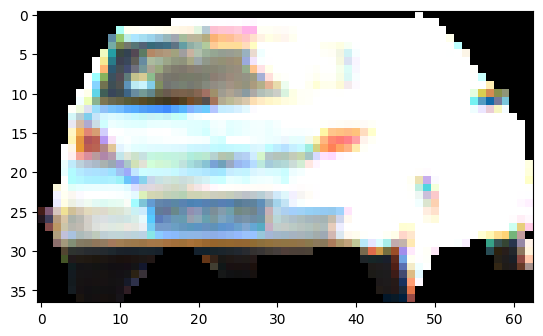

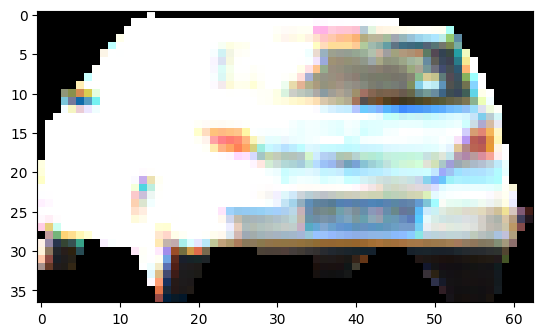

In [49]:
 from tools.visualize_util import plt_show
plt_show(image_db['000752_4'])
plt_show(image_db['000752_104'])